## **录音过程**

[截自:Matlab Audio Device Reader](https://www.mathworks.com/help/audio/ref/audiodevicereader.html)   


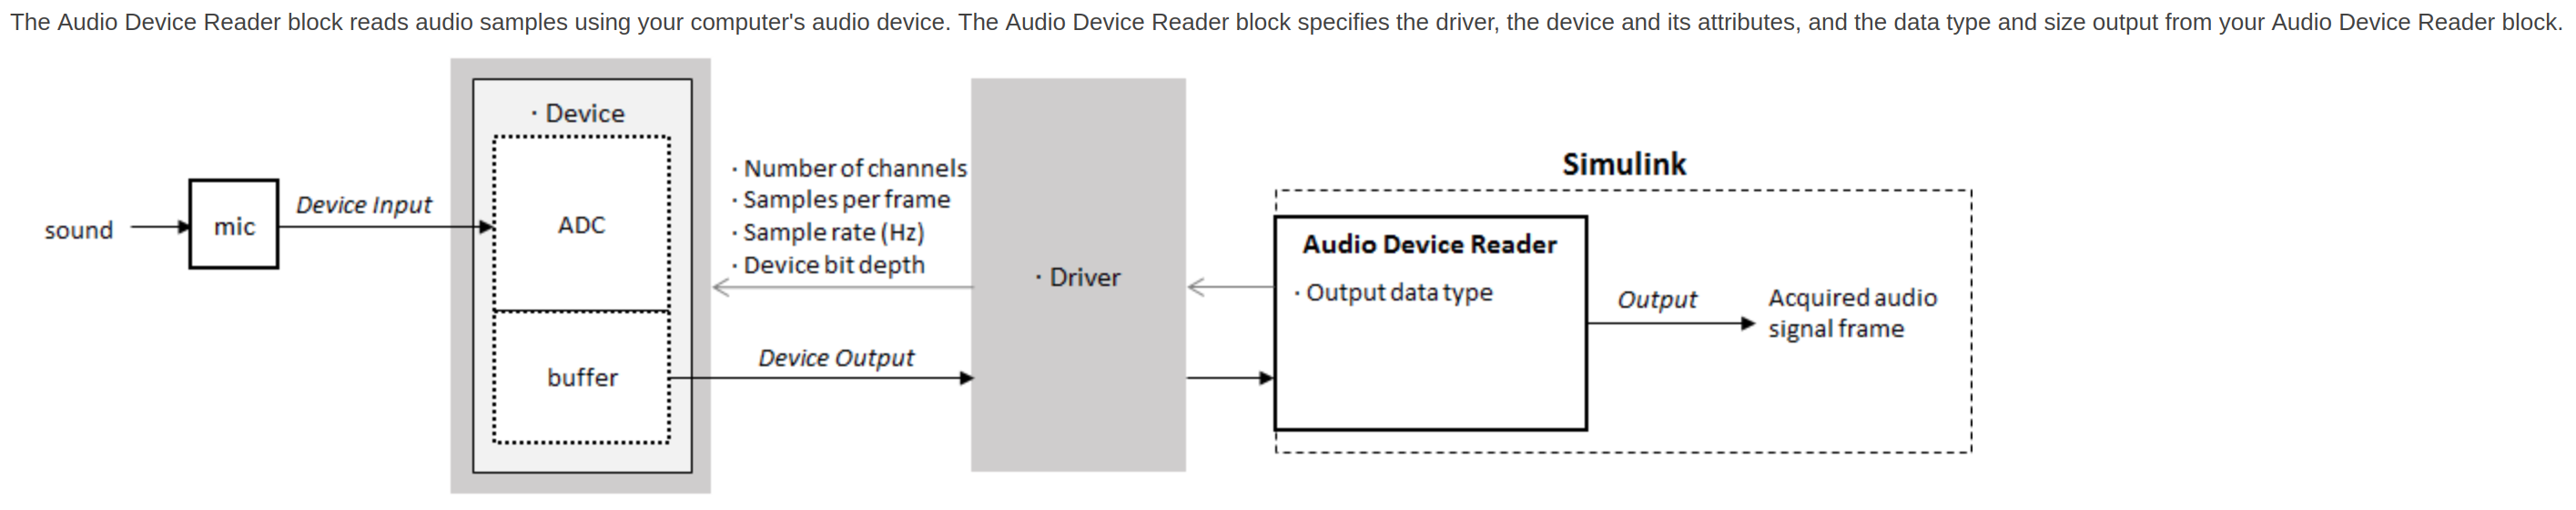

In [86]:
import IPython.display as ipd
ipd.Image("img/audio_read.png")

## **播放过程**

[截自Matlab Audio Device Writer](https://www.mathworks.com/help/audio/ref/audiodevicewriter.html)

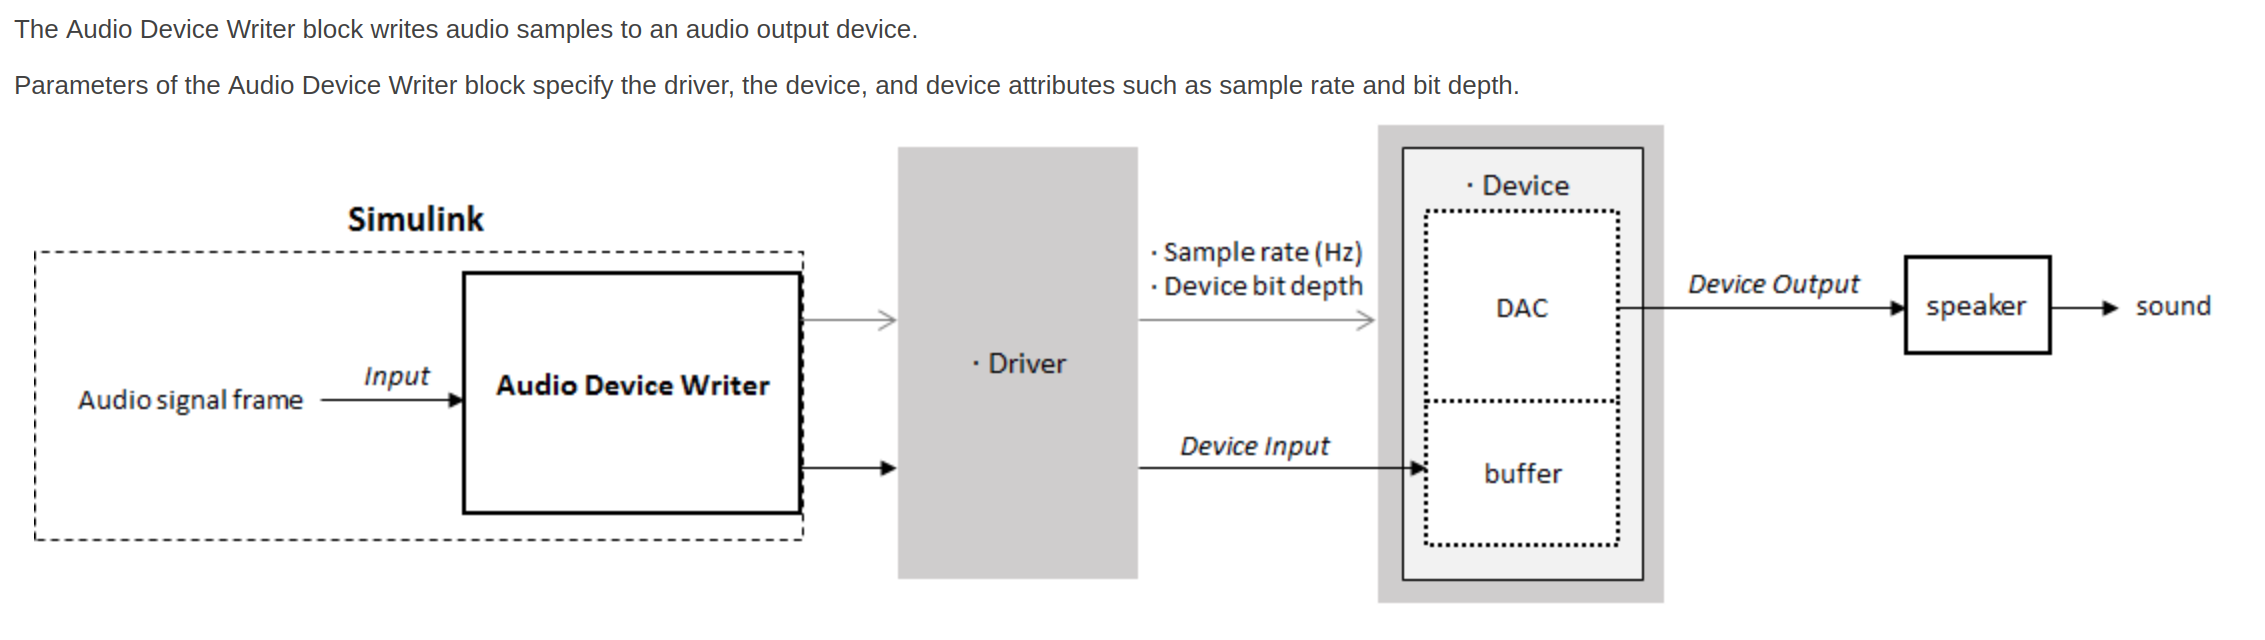

In [88]:
ipd.Image("img/audio_write.png")

## **同时录音和播放**

[截自 Audio I/O: Buffering, Latency, and Throughput](https://www.mathworks.com/help/audio/gs/audio-io-buffering-latency-and-throughput.html)

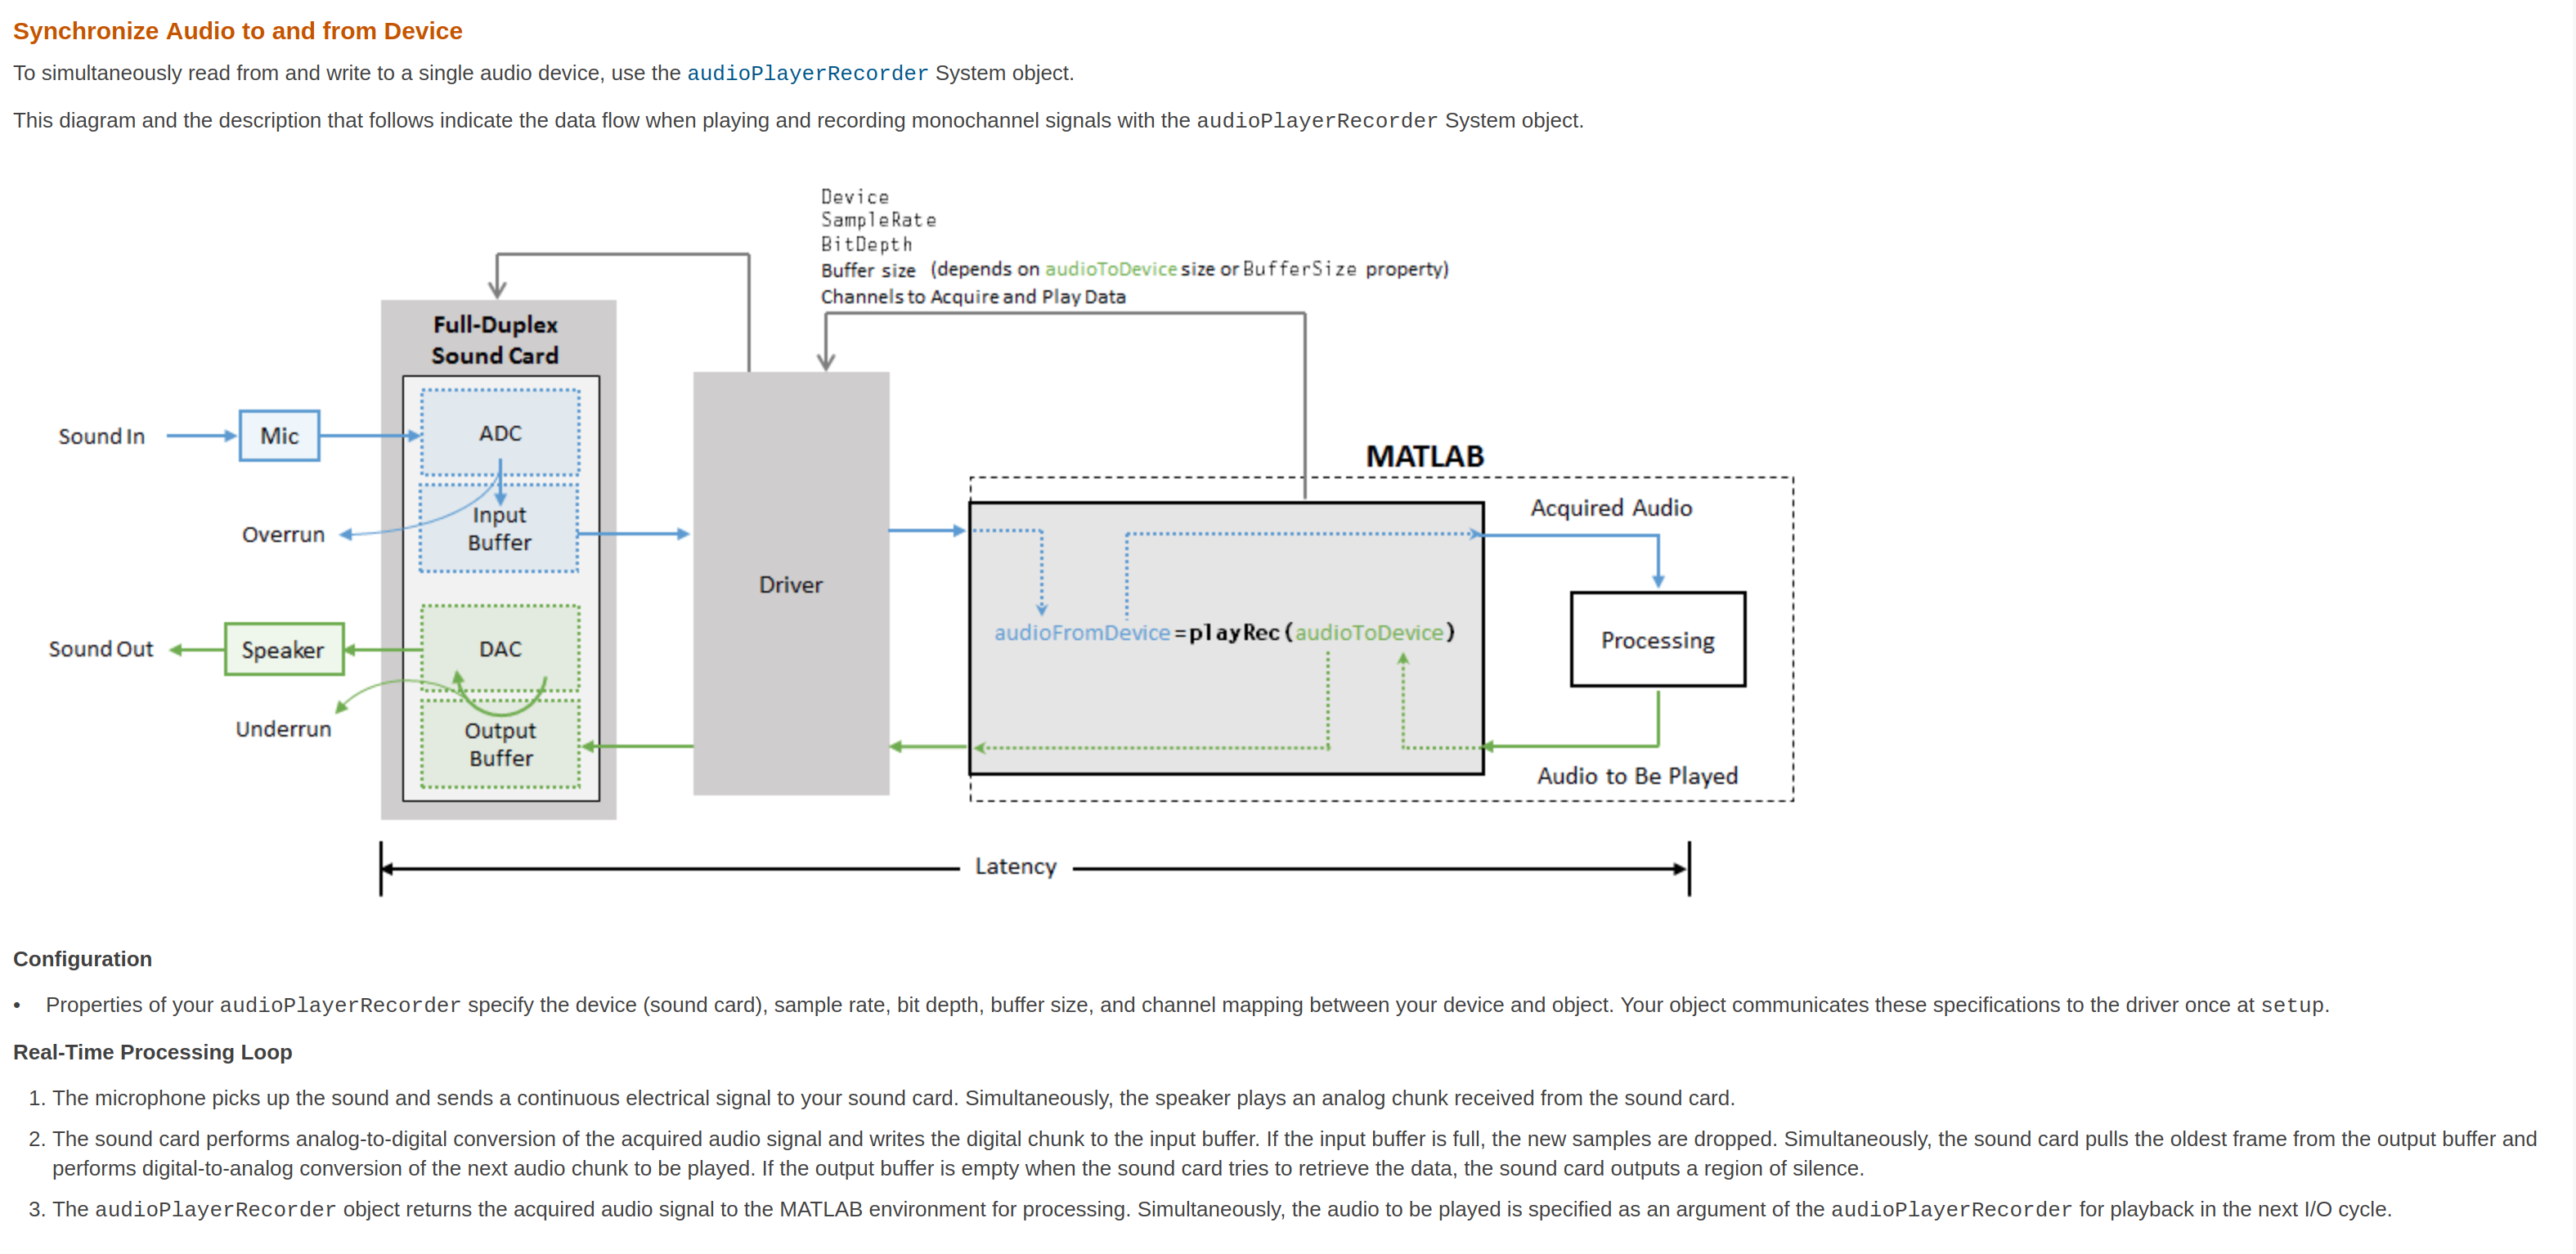

In [89]:
ipd.Image('img/synchronize_rec_read.png')

## **使用 Pyaudio 同时播放与录音**

在向 stream 写入数据以播放时，如果声道数写的 1，除非 rate 加倍（88200），否则播出来的音乐是有问题的，因为原文件是双声道采样

使用 wave 读取 .wav 音频文件中的数据，先**写入** stream 以 **播放**，然后迅速**读取**以**录音**

**唯一的问题是，录音保存后新生成的 .wav 音频文件播放时的响度小于原音频文件**，下面看一下标准化之后两个文件的振幅大小是否相同，如果标准化之后结果相同，就没有影响

In [129]:
import sounddevice as sd
import queue
import threading
import soundfile as sf

chunk = 1024
num_chunk_perBuffer = 20

q = queue.Queue(maxsize = num_chunk_perBuffer)

event = threading.Event()


def callback(outdata, frames, time, status):
    if status:
        print(status)

    data = q.get_nowait()
    outdata[:]=data


try:
    with sf.SoundFile("audio/magoo.wav") as sf:
        for i in range(num_chunk_perBuffer):
            data = sf.buffer_read(chunk, dtype="float32")
            q.put_nowait(data)
        stream = sd.RawOutputStream(
        samplerate = 44100, blocksize=chunk, channels=2, dtype="float32", callback=callback, 
        finished_callback = event.set)
        
        with stream:
            timeout = chunk*num_chunk_perBuffer/44100
            while data:
                data = sf.buffer_read(chunk, dtype="float32")
                q.put(data,timeout=timeout)
            
            event.wait()
            
except KeyboardInterrupt:
    print("stop")

output underflow
stop


In [110]:
myrecording = sd.playrec(myrecording,88100,channels=1)

In [111]:
myrecording

array([[  0],
       [  0],
       [  0],
       ...,
       [635],
       [667],
       [703]], dtype=int16)

In [109]:
frames

array([   -3,    -3,    -3, ..., -5198, -5848, -5210], dtype=int16)

In [99]:
sd.stop()

In [92]:
import pyaudio
import wave


FORMAT = pyaudio.paInt16
CHANNELS = 2
CHUNK = 1024
RATE = 44100


wf = wave.open('audio/song_seg.wav','rb')

audio = pyaudio.PyAudio()


stream = audio.open(format              = FORMAT,
                    channels            = CHANNELS,
                    rate                = RATE,
                    input               = True,
                    output              = True,
                    frames_per_buffer   = CHUNK)


data = wf.readframes(CHUNK)


try:
    
    frames = []
    print("* echoing")
    print("Press CTRL+C to stop")
    while len(data)>0:
        stream.write(data)
        data = wf.readframes(CHUNK)
        data1 = stream.read(CHUNK)
        frames.append(data1)
 
    print("* done echoing")
    
except KeyboardInterrupt:
    stream.stop_stream()
    stream.close()
    audio.terminate()

    
wavefile = wave.open('name1.wav', 'wb')
wavefile.setnchannels(2)
wavefile.setsampwidth(audio.get_sample_size(FORMAT))
wavefile.setframerate(RATE)
wavefile.writeframes(b''.join(frames))
wavefile.close()

* echoing
Press CTRL+C to stop
* done echoing


In [96]:
frames = np.fromstring(frames,dtype=np.int16)

<ipython-input-96-e86ef3ff738e>:1: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  frames = np.fromstring(frames,dtype=np.int16)


In [97]:
frames

array([   -3,    -3,    -3, ..., -5198, -5848, -5210], dtype=int16)

In [21]:
import pyaudio
import time
import wave
#import json


FORMAT = pyaudio.paInt16
CHANNELS =2
CHUNK = 1024
RATE = 44100


wf = wave.open('song_seg.wav','rb')

audio = pyaudio.PyAudio()

#for i in range(audio.get_device_count()):
    #print(json.dumps(audio.get_device_info_by_index(i), indent=2))

stream = audio.open(format              = FORMAT,
                    channels            = CHANNELS,
                    rate                = RATE,
                    #input               = True,
                    output              = True,
                    frames_per_buffer   = CHUNK)


data = wf.readframes(CHUNK)


try:
    
    print("* echoing")
    print("Press CTRL+C to stop")
    while len(data)>0:
        stream.write(data)
        data = wf.readframes(CHUNK)
        #time.sleep(0.02)

 
    print("* done echoing")
    
except KeyboardInterrupt:
    stream.stop_stream()
    stream.close()
    audio.terminate()



* echoing
Press CTRL+C to stop
* done echoing


In [101]:
import numpy as np

wf = wave.open('audio/song_seg.wav','rb')

data0 = wf.readframes(CHUNK)
data0 = np.fromstring(data0, dtype=np.int16)
  
    


<ipython-input-101-b83f7f0ec0df>:6: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data0 = np.fromstring(data0, dtype=np.int16)


In [102]:
data0

array([0, 0, 0, ..., 0, 0, 0], dtype=int16)

In [103]:
import numpy as np

wf = wave.open('audio/name1.wav','rb')

data1 = wf.readframes(CHUNK)
data1 = np.fromstring(data1, dtype=np.int16)

<ipython-input-103-5dcd5d4e78dd>:6: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data1 = np.fromstring(data1, dtype=np.int16)


In [105]:
data1

array([-1, -1, -1, ..., -1,  0,  0], dtype=int16)

In [64]:
import librosa
import librosa.display

In [66]:
x, sr =librosa.load('song_seg.wav')

In [67]:
x

array([0.        , 0.        , 0.        , ..., 0.15902197, 0.1381697 ,
       0.14052306], dtype=float32)

In [68]:
y, sr = librosa.load('name1.wav')

In [69]:
y

array([-2.5370311e-05, -2.4186240e-05,  1.8491925e-06, ...,
       -4.9020756e-02, -4.6681356e-02, -5.1159445e-02], dtype=float32)

In [39]:
import numpy as np

wf = wave.open('name1.wav','rb')

data1 = wf.readframes(CHUNK)
data1 = np.fromstring(data, dtype=np.int16)


<ipython-input-39-7b55652cf004>:6: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data1 = np.fromstring(data, dtype=np.int16)


In [56]:
wf.getnframes()

8968764

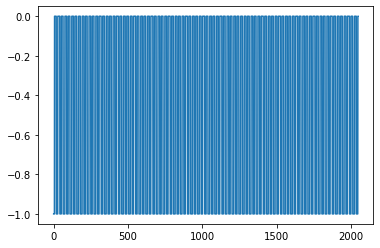

In [50]:
import matplotlib.pyplot as plt
plt.plot(data0)